You are a data scientist who applied for a machine learning position at one of the most prestigious banks in Azerbaijan. As a part of the recruitment process, you are tasked to evaluate the probability of default of the given loan. To protect the confidentiality of its customers and internal database structure, the financial institution has anonymized the entire dataset before sending it to the candidate.

* __Category__: #Financial data , #Classification
* __Dataset__: Load Default  
* __Dataset Link__: https://drive.google.com/open?id=1mrKSmWdOZnAI59jaRYEgS99zQJF8pOZg

## Imports

In [62]:
import os
import sys
import random
import warnings
import pprint
from collections import OrderedDict

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 33
seed_everything(seed=RANDOM_STATE)

In [63]:
# Read data
data = pd.read_csv('train.csv')

In [ ]:
data.head

In [64]:
data['loss'].head(20)

0     0 
1     0 
2     0 
3     0 
4     0 
5     0 
6     0 
7     1 
8     0 
9     0 
10    0 
11    0 
12    0 
13    0 
14    0 
15    0 
16    16
17    0 
18    0 
19    0 
Name: loss, dtype: int64

## Data Exploration and Feature Engineering

In [65]:
# Derive default
DEFAULT_CRITERION = 0
data['default'] = data['loss'].apply(lambda x: 1 if x > DEFAULT_CRITERION else 0)

In [66]:
data['default'].head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    0
9    0
Name: default, dtype: int64

In [67]:
data['default'].head(100)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     1
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    0
18    0
19    0
20    0
21    0
22    0
23    0
24    0
25    0
26    1
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
50    1
51    0
52    0
53    0
54    0
55    0
56    0
57    0
58    0
59    0
60    0
61    0
62    0
63    0
64    1
65    0
66    0
67    0
68    1
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    1
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    1
88    0
89    0
90    1
91    0
92    0
93    0
94    0
95    0
96    0
97    0
98    0
99    0
Name: default, dtype: int64

In [68]:
# Imbalamce check
data['default'].sum()/len(data)

0.09275535455243622

In [69]:
data.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,f285,f286,f287,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299,f300,f301,f302,f303,f304,f305,f306,f307,f308,f309,f310,f311,f312,f313,f314,f315,f316,f317,f318,f319,f320,f321,f322,f323,f324,f325,f326,f327,f328,f329,f330,f331,f332,f333,f334,f335,f336,f337,f338,f339,f340,f341,f342,f343,f344,f345,f346,f347,f348,f349,f350,f351,f352,f353,f354,f355,f356,f357,f358,f359,f360,f361,f362,f363,f364,f365,f366,f367,f368,f369,f370,f371,f372,f373,f374,f375,f376,f377,f378,f379,f380,f381,f382,f383,f384,f385,f386,f387,f388,f389,f390,f391,f392,f393,f394,f395,f396,f397,f398,f399,f400,f401,f402,f403,f404,f405,f406,f407,f408,f409,f410,f411,f412,f413,f414,f415,f416,f417,f418,f419,f420,f421,f422,f423,f424,f425,f426,f427,f428,f429,f430,f431,f432,f433,f434,f435,f436,f437,f438,f439,f440,f441,f442,f443,f444,f445,f446,f447,f448,f449,f450,f451,f452,f453,f454,f455,f456,f457,f458,f459,f460,f461,f464,f465,f466,f467,f468,f469,f470,f471,f472,f475,f476,f477,f478,f479,f480,f481,f482,f483,f484,f485,f486,f487,f488,f489,f490,f491,f492,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502,f503,f504,f505,f506,f507,f508,f509,f510,f511,f512,f513,f514,f515,f516,f517,f518,f519,f520,f521,f522,f523,f524,f525,f526,f527,f528,f529,f530,f531,f532,f533,f534,f535,f536,f537,f538,f539,f540,f541,f542,f543,f544,f545,f546,f547,f548,f549,f550,f551,f552,f553,f554,f555,f556,f557,f558,f559,f560,f561,f562,f563,f564,f565,f566,f567,f568,f569,f570,f571,f572,f573,f574,f575,f576,f577,f578,f579,f580,f581,f582,f583,f584,f585,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595,f596,f597,f598,f599,f600,f601,f604,f606,f607,f608,f609,f610,f611,f612,f613,f614,f615,f616,f617,f618,f619,f620,f621,f622,f623,f624,f625,f626,f627,f628,f629,f630,f631,f632,f633,f634,f635,f636,f637,f638,f639,f640,f641,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651,f652,f653,f654,f655,f656,f657,f658,f659,f660,f661,f662,f663,f664,f665,f666,f667,f668,f669,f670,f671,f672,f673,f674,f675,f676,f677,f678,f679,f680,f681,f682,f683,f684,f685,f686,f687,f688,f689,f690,f691,f692,f693,f694,f695,f696,f697,f698,f699,f700,f701,f702,f703,f704,f705,f706,f707,f708,f709,f710,f711,f712,f713,f714,f715,f716,f717,f718,f719,f720,f721,f722,f723,f724,f725,f726,f727,f728,f729,f730,f731,f732,f733,f734,f735,f736,f737,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss,default
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,5.0,0.026826,1.0374

In [70]:
data.loc[data['default'] == 0].head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,f285,f286,f287,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299,f300,f301,f302,f303,f304,f305,f306,f307,f308,f309,f310,f311,f312,f313,f314,f315,f316,f317,f318,f319,f320,f321,f322,f323,f324,f325,f326,f327,f328,f329,f330,f331,f332,f333,f334,f335,f336,f337,f338,f339,f340,f341,f342,f343,f344,f345,f346,f347,f348,f349,f350,f351,f352,f353,f354,f355,f356,f357,f358,f359,f360,f361,f362,f363,f364,f365,f366,f367,f368,f369,f370,f371,f372,f373,f374,f375,f376,f377,f378,f379,f380,f381,f382,f383,f384,f385,f386,f387,f388,f389,f390,f391,f392,f393,f394,f395,f396,f397,f398,f399,f400,f401,f402,f403,f404,f405,f406,f407,f408,f409,f410,f411,f412,f413,f414,f415,f416,f417,f418,f419,f420,f421,f422,f423,f424,f425,f426,f427,f428,f429,f430,f431,f432,f433,f434,f435,f436,f437,f438,f439,f440,f441,f442,f443,f444,f445,f446,f447,f448,f449,f450,f451,f452,f453,f454,f455,f456,f457,f458,f459,f460,f461,f464,f465,f466,f467,f468,f469,f470,f471,f472,f475,f476,f477,f478,f479,f480,f481,f482,f483,f484,f485,f486,f487,f488,f489,f490,f491,f492,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502,f503,f504,f505,f506,f507,f508,f509,f510,f511,f512,f513,f514,f515,f516,f517,f518,f519,f520,f521,f522,f523,f524,f525,f526,f527,f528,f529,f530,f531,f532,f533,f534,f535,f536,f537,f538,f539,f540,f541,f542,f543,f544,f545,f546,f547,f548,f549,f550,f551,f552,f553,f554,f555,f556,f557,f558,f559,f560,f561,f562,f563,f564,f565,f566,f567,f568,f569,f570,f571,f572,f573,f574,f575,f576,f577,f578,f579,f580,f581,f582,f583,f584,f585,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595,f596,f597,f598,f599,f600,f601,f604,f606,f607,f608,f609,f610,f611,f612,f613,f614,f615,f616,f617,f618,f619,f620,f621,f622,f623,f624,f625,f626,f627,f628,f629,f630,f631,f632,f633,f634,f635,f636,f637,f638,f639,f640,f641,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651,f652,f653,f654,f655,f656,f657,f658,f659,f660,f661,f662,f663,f664,f665,f666,f667,f668,f669,f670,f671,f672,f673,f674,f675,f676,f677,f678,f679,f680,f681,f682,f683,f684,f685,f686,f687,f688,f689,f690,f691,f692,f693,f694,f695,f696,f697,f698,f699,f700,f701,f702,f703,f704,f705,f706,f707,f708,f709,f710,f711,f712,f713,f714,f715,f716,f717,f718,f719,f720,f721,f722,f723,f724,f725,f726,f727,f728,f729,f730,f731,f732,f733,f734,f735,f736,f737,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss,default
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,126.03,7,0.7607,0.7542,612922,0.7236,0.7236,0.5171,0.7236,0.8476,0.7876,1.097851e+09,89,66,998046.0,89.0,89.0,89.00,89.00,89.0,0.9271,0,0,0,5,0,0,0.73180,0.72124,0.749280,5.0,0.026826,1.0374

In [71]:
data.loc[data['default'] == 0].head().index

Int64Index([0, 1, 2, 3, 4], dtype='int64')

In [72]:
list(data.loc[data['default'] == 0].head().index)

[0, 1, 2, 3, 4]

In [73]:
# Under - sampling, choose indices to drop to achieve more balanced dataset
non_default_index = list(data.loc[data['default'] == 0].index)

In [74]:
drop_index = np.random.choice(non_default_index, int(0.90 * len(non_default_index)), replace=False )

In [75]:
drop_index[0:10]

array([54128, 96438, 97077, 97038, 22758, 67123, 15939, 96652, 39213,
       91548])

In [76]:
# Check data imbalance
data = data.drop(index=drop_index, axis=0).reset_index()
data['default'].sum()/len(data)

0.5055291442744936

In [77]:
# Seperate labels and predictors
y_data = data[['default']]
X_data = data.drop(columns=['loss', 'default', 'id'], axis=1)

In [78]:
X_data.head()

,index,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,f285,f286,f287,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299,f300,f301,f302,f303,f304,f305,f306,f307,f308,f309,f310,f311,f312,f313,f314,f315,f316,f317,f318,f319,f320,f321,f322,f323,f324,f325,f326,f327,f328,f329,f330,f331,f332,f333,f334,f335,f336,f337,f338,f339,f340,f341,f342,f343,f344,f345,f346,f347,f348,f349,f350,f351,f352,f353,f354,f355,f356,f357,f358,f359,f360,f361,f362,f363,f364,f365,f366,f367,f368,f369,f370,f371,f372,f373,f374,f375,f376,f377,f378,f379,f380,f381,f382,f383,f384,f385,f386,f387,f388,f389,f390,f391,f392,f393,f394,f395,f396,f397,f398,f399,f400,f401,f402,f403,f404,f405,f406,f407,f408,f409,f410,f411,f412,f413,f414,f415,f416,f417,f418,f419,f420,f421,f422,f423,f424,f425,f426,f427,f428,f429,f430,f431,f432,f433,f434,f435,f436,f437,f438,f439,f440,f441,f442,f443,f444,f445,f446,f447,f448,f449,f450,f451,f452,f453,f454,f455,f456,f457,f458,f459,f460,f461,f464,f465,f466,f467,f468,f469,f470,f471,f472,f475,f476,f477,f478,f479,f480,f481,f482,f483,f484,f485,f486,f487,f488,f489,f490,f491,f492,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502,f503,f504,f505,f506,f507,f508,f509,f510,f511,f512,f513,f514,f515,f516,f517,f518,f519,f520,f521,f522,f523,f524,f525,f526,f527,f528,f529,f530,f531,f532,f533,f534,f535,f536,f537,f538,f539,f540,f541,f542,f543,f544,f545,f546,f547,f548,f549,f550,f551,f552,f553,f554,f555,f556,f557,f558,f559,f560,f561,f562,f563,f564,f565,f566,f567,f568,f569,f570,f571,f572,f573,f574,f575,f576,f577,f578,f579,f580,f581,f582,f583,f584,f585,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595,f596,f597,f598,f599,f600,f601,f604,f606,f607,f608,f609,f610,f611,f612,f613,f614,f615,f616,f617,f618,f619,f620,f621,f622,f623,f624,f625,f626,f627,f628,f629,f630,f631,f632,f633,f634,f635,f636,f637,f638,f639,f640,f641,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651,f652,f653,f654,f655,f656,f657,f658,f659,f660,f661,f662,f663,f664,f665,f666,f667,f668,f669,f670,f671,f672,f673,f674,f675,f676,f677,f678,f679,f680,f681,f682,f683,f684,f685,f686,f687,f688,f689,f690,f691,f692,f693,f694,f695,f696,f697,f698,f699,f700,f701,f702,f703,f704,f705,f706,f707,f708,f709,f710,f711,f712,f713,f714,f715,f716,f717,f718,f719,f720,f721,f722,f723,f724,f725,f726,f727,f728,f729,f730,f731,f732,f733,f734,f735,f736,f737,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,7,128,9,0.385778,2900,4,79244,6597.0,3592.0,127.19,127.89,6,0.8596,0.7967,17175731,0.8033,0.7538,0.5868,0.8376,0.9159,0.8522,3.127331e+09,98,75,1219708.0,98.0,98.0,120.79,108.46,98.0,0.9899,0,0,0,17,0,0,0.72690,0.73842,0.739165,17.0,0.092005,-0.928703,

In [79]:
X_data.head()

,index,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,f41,f42,f43,f44,f45,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55,f56,f57,f58,f59,f60,f61,f62,f63,f64,f65,f66,f67,f68,f69,f70,f71,f72,f73,f74,f75,f76,f77,f78,f79,f80,f81,f82,f83,f84,f85,f86,f87,f88,f89,f90,f91,f92,f93,f94,f95,f96,f97,f98,f99,f100,f101,f102,f103,f104,f105,f106,f107,f108,f109,f110,f111,f112,f113,f114,f115,f116,f117,f118,f119,f120,f121,f122,f123,f124,f125,f126,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,f167,f168,f169,f170,f171,f172,f173,f174,f175,f176,f177,f178,f179,f180,f181,f182,f183,f184,f185,f186,f187,f188,f189,f190,f191,f192,f193,f194,f195,f196,f197,f198,f199,f200,f201,f202,f203,f204,f205,f206,f207,f208,f209,f210,f211,f212,f213,f214,f215,f216,f217,f218,f219,f220,f221,f222,f223,f224,f225,f226,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f243,f244,f245,f246,f247,f248,f249,f250,f251,f252,f253,f254,f255,f256,f257,f258,f259,f260,f261,f262,f263,f264,f265,f266,f267,f268,f269,f270,f271,f272,f273,f274,f275,f276,f277,f278,f279,f280,f281,f282,f283,f284,f285,f286,f287,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297,f298,f299,f300,f301,f302,f303,f304,f305,f306,f307,f308,f309,f310,f311,f312,f313,f314,f315,f316,f317,f318,f319,f320,f321,f322,f323,f324,f325,f326,f327,f328,f329,f330,f331,f332,f333,f334,f335,f336,f337,f338,f339,f340,f341,f342,f343,f344,f345,f346,f347,f348,f349,f350,f351,f352,f353,f354,f355,f356,f357,f358,f359,f360,f361,f362,f363,f364,f365,f366,f367,f368,f369,f370,f371,f372,f373,f374,f375,f376,f377,f378,f379,f380,f381,f382,f383,f384,f385,f386,f387,f388,f389,f390,f391,f392,f393,f394,f395,f396,f397,f398,f399,f400,f401,f402,f403,f404,f405,f406,f407,f408,f409,f410,f411,f412,f413,f414,f415,f416,f417,f418,f419,f420,f421,f422,f423,f424,f425,f426,f427,f428,f429,f430,f431,f432,f433,f434,f435,f436,f437,f438,f439,f440,f441,f442,f443,f444,f445,f446,f447,f448,f449,f450,f451,f452,f453,f454,f455,f456,f457,f458,f459,f460,f461,f464,f465,f466,f467,f468,f469,f470,f471,f472,f475,f476,f477,f478,f479,f480,f481,f482,f483,f484,f485,f486,f487,f488,f489,f490,f491,f492,f493,f494,f495,f496,f497,f498,f499,f500,f501,f502,f503,f504,f505,f506,f507,f508,f509,f510,f511,f512,f513,f514,f515,f516,f517,f518,f519,f520,f521,f522,f523,f524,f525,f526,f527,f528,f529,f530,f531,f532,f533,f534,f535,f536,f537,f538,f539,f540,f541,f542,f543,f544,f545,f546,f547,f548,f549,f550,f551,f552,f553,f554,f555,f556,f557,f558,f559,f560,f561,f562,f563,f564,f565,f566,f567,f568,f569,f570,f571,f572,f573,f574,f575,f576,f577,f578,f579,f580,f581,f582,f583,f584,f585,f586,f587,f588,f589,f590,f591,f592,f593,f594,f595,f596,f597,f598,f599,f600,f601,f604,f606,f607,f608,f609,f610,f611,f612,f613,f614,f615,f616,f617,f618,f619,f620,f621,f622,f623,f624,f625,f626,f627,f628,f629,f630,f631,f632,f633,f634,f635,f636,f637,f638,f639,f640,f641,f642,f643,f644,f645,f646,f647,f648,f649,f650,f651,f652,f653,f654,f655,f656,f657,f658,f659,f660,f661,f662,f663,f664,f665,f666,f667,f668,f669,f670,f671,f672,f673,f674,f675,f676,f677,f678,f679,f680,f681,f682,f683,f684,f685,f686,f687,f688,f689,f690,f691,f692,f693,f694,f695,f696,f697,f698,f699,f700,f701,f702,f703,f704,f705,f706,f707,f708,f709,f710,f711,f712,f713,f714,f715,f716,f717,f718,f719,f720,f721,f722,f723,f724,f725,f726,f727,f728,f729,f730,f731,f732,f733,f734,f735,f736,f737,f738,f739,f740,f741,f742,f743,f744,f745,f746,f747,f748,f749,f750,f751,f752,f753,f754,f755,f756,f757,f758,f759,f760,f761,f762,f763,f764,f765,f766,f767,f768,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,7,128,9,0.385778,2900,4,79244,6597.0,3592.0,127.19,127.89,6,0.8596,0.7967,17175731,0.8033,0.7538,0.5868,0.8376,0.9159,0.8522,3.127331e+09,98,75,1219708.0,98.0,98.0,120.79,108.46,98.0,0.9899,0,0,0,17,0,0,0.72690,0.73842,0.739165,17.0,0.092005,-0.928703,

In [80]:
X_data.shape

(19352, 770)

In [81]:
# Reduce columns
cn = 100
X_columns = X_data.columns
X_columns = np.random.choice(X_columns, cn, replace=False)
X_data = X_data[X_columns]

In [82]:
X_data.columns[0:10]

Index(['f460', 'f317', 'f764', 'f235', 'f599', 'f133', 'f188', 'f270', 'f229',
       'f148'],
      dtype='object')

In [83]:
X_data.shape

(19352, 100)

In [84]:
X_data.head()

,f460,f317,f764,f235,f599,f133,f188,f270,f229,f148,f324,f516,f628,f398,f84,f361,f75,f667,f676,f258,f536,f695,f395,f450,f609,f423,f294,f634,f668,f265,f530,f76,f357,f487,f401,f758,f32,f405,f6,f767,f106,f385,f29,f658,f629,f296,f647,f723,f545,f181,f156,f155,f123,f223,f635,f527,f147,f269,f169,f177,f320,f351,f729,f80,f587,f619,f565,f547,f231,f230,f353,f356,f554,f509,f493,f638,f15,f305,f218,f238,f215,f370,f298,f681,f400,f600,f340,f598,f413,f213,f182,f544,f381,f575,f654,f107,f712,f466,f501,f445
0,475.45,4,1,536.0,6,156.07,0.41,1.03,1.21,6814611.0,0.35,6.875,9.038376e+08,0.0084,0.14,115.26000,8.16,70066.0,0.29,0.46,1.18,153690081628869984256,0.0069,5.2027,0.960852,4.715,3,4.212,4805398.0,1535.0,11467286641,9.31,-1.09700,7.040467e+09,3.454519e+09,8.7296,0.9899,0.351,79244,-0.649,745.0,1.5273,120.79,21108985,0.3995,3,1.253322,0.0,269.08,0.07,60.0,60.0,0.09,0.16,3.715,7741241.58,445803.0,0.67,1.36,57.0,4,89.71,18,1.37,0.39,0.07,221.50,6.790000e+13,0.01,1.44,89.17647,8.92607,1.350000e+11,0.40,836.75,1.03141,0.7967,0.24,4.50,0.36,181572.0,100.82529,0.50,17,2,-0.12,1.16,2.535,1.191718,5.50,0.00,1.510000e+11,4528467,533.88,21.84,745.0,15.7955,6.740000e+17,420.00,30414.77
1,143.53,14,1,315.0,14,0.00,0.43,1.18,1.49,2867234.0,0.33,5.400,4.103448e+08,0.0788,0.07,110.73574,10.43,337025.0,0.86,0.38,1.13,204996731568980000768,0.0345,6.3254,1.082509,5.790,5,25.846,27425965.0,824.0,3006648570,8.74,-1.65918,3.995891e+08,2.588121e+09,34.2219,0.9459,0.864,11255,-0.136,333.0,1.6850,138.75,28985650,0.4640,5,2.128833,0.0,101.87,0.01,11.0,11.0,0.00,0.07,51.865,2270923.47,155980.0,0.99,1.20,12.0,14,99.72,55,0.97,0.33,0.00,136.87,1.130000e+12,0.01,1.86,97.53704,15.65923,2.316711e+10,0.43,299.00,1.43389,0.8974,0.37,4.56,0.31,196077.0,103.53407,0.01,54,6,0.06,1.80,8.644,1.220668,6.73,0.00,6.644384e+09,26039219,257.44,69.03,333.0,49.6464,1.470000e+16,143.97,20462.78
2,76.41,6,1,13.0,14,0.00,0.38,1.25,1.53,3671583.0,0.30,5.945,5.803758e+08,0.1325,0.06,103.30741,11.65,98680.0,0.61,0.34,1.34,111014290641749999616,0.0863,7.1733,0.851197,5.845,2,6.682,6253956.0,42.0,7089256,12.78,-1.19822,4.922032e+07,1.490002e+09,14.4526,0.8454,0.579,14694,-0.421,154.0,1.2694,82.00,44199281,0.5195,2,1.420936,0.0,5.17,0.06,20.0,20.0,0.00,0.06,4.864,68060.92,264423.0,1.06,1.36,30.0,6,89.36,28,0.85,-0.24,0.00,10.12,3.105590e+05,0.03,1.94,89.70370,11.09159,4.992700e+04,-0.69,115.00,0.73342,0.6613,0.36,4.14,0.27,11133.0,95.87074,0.02,27,11,-0.31,1.34,8.060,1.139163,7.04,0.00,3.988700e+04,5361061,9.84,58.49,154.0,24.8534,8.840000e+14,63.23,13844.55
3,48.39,0,1,288.0,13,1052.03,0.45,1.13,1.39,2655227.0,0.25,5.915,4.297854e+08,0.1556,0.12,91.67125,2.81,26055.0,0.58,0.41,1.14,18575689613183000576,0.0612,5.9861,0.894577,7.295,0,3.476,1722065.0,859.0,9371276407,1.94,-1.02582,8.795628e+06,1.486742e+09,3.4009,0.8889,0.582,85793,-0.418,91.0,1.5096,88.00,4851248,0.4705,0,1.288046,0.0,140.56,0.32,77.0,77.0,0.99,0.10,4.088,6172524.27,211315.0,0.93,1.33,47.0,0,87.12,9,0.95,-0.05,0.00,147.89,3.130000e+12,0.08,1.69,85.00000,8.39643,1.638451e+10,0.37,83.50,1.17810,0.7097,0.00,4.20,0.31,151206.0,88.07750,0.00,8,7,0.45,1.09,6.332,1.236822,6.15,0.09,1.432016e+10,1440014,285.18,36.24,91.0,7.1731,1.760000e+14,45.10,4405.80
4,143.56,0,1,151.0,13,2331.00,0.00,1.19,1.38,49041.0,0.00,7.395,1.016577e+08,0.1041,0.07,95.23333,5.72,5329.0,0.71,0.40,1.14,8060000000000000000,0.0664,6.3265,1.082296,10.715,0,0.832,389017.0,447.0,1269636650,1.77,-0.66717,3.999163e+08,1.749732e+09,1.3672,0.8846,0.679,83607,-0.321,333.0,1.1067,92.00,11836593,0.5350,0,-3.007716,0.0,66.06,0.00,0.0,0.0,0.90,0.10,0.475,2030840.00,3869.0,0.99,NaN,0.0,0,89.25,4,0.97,-0.05,NaN,68.01,1.440000e+11,0.01,1.68,88.33333,3.29983,1.095022e+09,0.43,299.00,-0.86634,0.7541,0.00,4.70,0.29,108857.0,91.50000,0.00,3,10,0.72,NaN,6.332,1.105320,6.87,0.00,1.181082e+09,872388,129.25,131.00,333.0,2.7056,1.480000e+16,144.01,20472.45


In [85]:
X_data.shape

(19352, 100)

In [86]:
X_data.dtypes

f460    float64
f317    int64  
f764    int64  
f235    float64
f599    int64  
f133    float64
f188    float64
f270    float64
f229    float64
f148    float64
f324    float64
f516    float64
f628    float64
f398    float64
f84     float64
f361    float64
f75     float64
f667    float64
f676    float64
f258    float64
f536    float64
f695    object 
f395    float64
f450    float64
f609    float64
f423    float64
f294    int64  
f634    float64
f668    float64
f265    float64
f530    int64  
f76     float64
f357    float64
f487    float64
f401    float64
f758    float64
f32     float64
f405    float64
f6      int64  
f767    float64
f106    float64
f385    float64
f29     float64
f658    int64  
f629    float64
f296    int64  
f647    float64
f723    float64
f545    float64
f181    float64
f156    float64
f155    float64
f123    float64
f223    float64
f635    float64
f527    float64
f147    float64
f269    float64
f169    float64
f177    float64
f320    int64  
f351    float64
f729    

In [87]:
X_data.describe()

,f460,f317,f764,f235,f599,f133,f188,f270,f229,f148,f324,f516,f628,f398,f84,f361,f75,f667,f676,f258,f536,f395,f450,f609,f423,f294,f634,f668,f265,f530,f76,f357,f487,f401,f758,f32,f405,f6,f767,f106,f385,f29,f658,f629,f296,f647,f723,f545,f181,f156,f155,f123,f223,f635,f527,f147,f269,f169,f177,f320,f351,f729,f80,f587,f619,f565,f547,f231,f230,f353,f356,f554,f509,f493,f638,f15,f305,f218,f238,f215,f370,f298,f681,f400,f600,f340,f598,f413,f213,f182,f544,f381,f575,f654,f107,f712,f466,f501,f445
count,19329.000000,19352.000000,19352.0,19337.000000,19352.000000,19307.000000,19134.000000,19279.000000,19196.000000,1.913400e+04,19352.00000,19331.000000,1.925000e+04,19103.000000,19329.000000,19352.000000,19307.000000,1.750300e+04,19352.000000,19337.000000,19292.000000,19352.000000,19352.000000,19301.000000,19352.000000,19352.000000,19336.000000,1.750300e+04,19337.000000,1.935200e+04,19307.000000,19196.000000,1.932900e+04,1.925000e+04,19248.000000,18929.000000,19352.000000,19352.000000,19352.000000,19329.000000,19261.000000,19352.000000,1.935200e+04,19312.000000,19352.000000,19231.000000,19352.000000,19337.000000,18923.000000,19134.000000,19134.000000,19307.000000,19337.000000,19336.000000,1.933700e+04,1.913400e+04,19279.000000,16313.000000,19134.000000,19352.000000,19352.000000,19352.000000,19306.000000,17775.000000,16419.000000,19337.000000,1.933700e+04,19322.000000,19196.000000,19352.000000,19351.000000,1.933700e+04,19120.000000,19307.000000,19208.000000,19347.000000,19352.000000,19337.000000,19337.000000,19337.000000,19352.000000,19352.000000,19352.000000,19352.000000,19302.000000,17814.000000,19352.000000,19295.000000,19337.000000,18923.000000,1.933700e+04,1.935200e+04,19337.000000,19352.000000,19329.000000,19327.000000,1.935200e+04,19329.000000,19352.000000
mean,171.830368,4.113735,1.0,275.213787,10.185407,1252.439078,0.363738,1.187136,1.406677,7.977289e+06,0.36270,5.812255,6.947853e+08,0.115547,0.097919,102.149371,6.110051,1.015322e+05,0.483654,0.389266,1.173167,0.070558,6.353015,0.922677,5.729084,2.069347,8.328808,9.035616e+06,829.345141,9.981353e+09,6.071840,-0.622903,2.029515e+09,3.353320e+09,8.559083,0.881401,0.484814,47439.172644,-0.515452,315.250246,1.282159,107.003672,4.552248e+07,0.483031,2.069347,1.234038,0.000286,145.547512,0.237122,39.976638,39.976638,0.313932,0.101637,21.505530,4.101285e+06,2.464867e+05,0.943213,1.353945,30.108080,4.113735,88.203932,17.881098,0.975527,19.660528,0.341940,129.701008,2.409680e+14,0.112483,1.733201,86.185226,18.644739,2.253011e+11,0.141407,331.409284,0.722938,0.697707,0.241924,4.319206,0.292624,151307.618607,91.047905,0.131234,16.988632,5.493437,-0.007381,1.061437,5.386658,1.119778,6.545544,0.238360,2.775571e+11,7.855074e+06,282.124458,49.573059,315.250246,14.604209,1.492258e+17,162.038755,17637.329406
std,187.811064,4.545810,0.0,278.065072,3.856763,6656.987787,0.130812,0.142336,0.152777,3.869224e+07,0.22181,1.332306,5.372844e+08,0.155784,0.039743,22.459682,2.450189,1.177032e+05,0.283307,0.058299,0.275571,0.096760,0.661220,0.252109,2.043323,2.460278,24.525703,1.199996e+07,836.240270,2.122219e+10,3.598591,0.755448,4.429602e+09,2.226354e+09,10.342011,0.198711,0.262080,35710.795537,0.262064,278.122318,0.266157,40.262064,1.180120e+08,0.405794,2.460278,1.528269,0.013985,155.747017,0.265295,147.445724,147.445724,0.422349,0.044895,679.851771,6.944266e+06,8.729436e+05,0.227986,0.236287,99.461965,4.545810,20.582934,17.487616,0.233871,403.729141,1.474771,127.238791,9.288568e+14,0.178921,0.246902,17.006752,16.849862,7.918727e+11,0.478690,315.071895,0.757441,0.234889,0.178061,0.506938,0.046707,132007.259335,18.393894,0.205252,17.487681,3.973448,0.383122,0.455190,2.254827,0.807485,0.890858,0.390153,9.132053e+11,1.061723e+07,293.195786,52.937969,278.122318,15.987736,6.484594e+17,155.776605,14086.593959
min,0.000000,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,0.990000,-1.060000,1.000000e+00,0.00000,1.720000,0.000000e+00,0.000000,0.000000,0.000000,1.050000,4.000000e+00,0.030000,0.000000,1.030000,0.000000,3.02

In [88]:
X_data.nunique()

f460    14508
f317    37   
f764    1    
f235    1198 
f599    32   
f133    12226
f188    44   
f270    108  
f229    130  
f148    18226
f324    92   
f516    1543 
f628    18992
f398    4086 
f84     33   
f361    17684
f75     1280 
f667    14626
f676    93   
f258    42   
f536    124  
f695    17956
f395    3054 
f450    12099
f609    18706
f423    1902 
f294    21   
f634    10664
f668    15177
f265    3150 
f530    19130
f76     1605 
f357    16250
f487    18963
f401    16871
f758    17672
f32     1344 
f405    775  
f6      767  
f767    774  
f106    1050 
f385    6256 
f29     855  
f658    18986
f629    3110 
f296    21   
f647    19177
f723    119  
f545    14083
f181    101  
f156    659  
f155    659  
f123    8    
f223    37   
f635    11046
f527    19294
f147    16974
f269    190  
f169    149  
f177    440  
f320    37   
f351    7124 
f729    132  
f80     224  
f587    889  
f619    541  
f565    14041
f547    11558
f231    90   
f230    188  
f353    10510
f356  

In [89]:
X_data.isnull().sum()

f460    23  
f317    0   
f764    0   
f235    15  
f599    0   
f133    45  
f188    218 
f270    73  
f229    156 
f148    218 
f324    0   
f516    21  
f628    102 
f398    249 
f84     23  
f361    0   
f75     45  
f667    1849
f676    0   
f258    15  
f536    60  
f695    102 
f395    0   
f450    0   
f609    51  
f423    0   
f294    0   
f634    16  
f668    1849
f265    15  
f530    0   
f76     45  
f357    156 
f487    23  
f401    102 
f758    104 
f32     423 
f405    0   
f6      0   
f767    0   
f106    23  
f385    91  
f29     0   
f658    0   
f629    40  
f296    0   
f647    121 
f723    0   
f545    15  
f181    429 
f156    218 
f155    218 
f123    45  
f223    15  
f635    16  
f527    15  
f147    218 
f269    73  
f169    3039
f177    218 
f320    0   
f351    0   
f729    0   
f80     46  
f587    1577
f619    2933
f565    15  
f547    15  
f231    30  
f230    156 
f353    0   
f356    1   
f554    15  
f509    232 
f493    45  
f638    144 
f15     5   

In [90]:
# Check nulls
null_rate = np.around(X_data.isnull().sum() / len(X_data) * 100, 3)
print(type(null_rate))
null_rate

<class 'pandas.core.series.Series'>


f460    0.119 
f317    0.000 
f764    0.000 
f235    0.078 
f599    0.000 
f133    0.233 
f188    1.126 
f270    0.377 
f229    0.806 
f148    1.126 
f324    0.000 
f516    0.109 
f628    0.527 
f398    1.287 
f84     0.119 
f361    0.000 
f75     0.233 
f667    9.555 
f676    0.000 
f258    0.078 
f536    0.310 
f695    0.527 
f395    0.000 
f450    0.000 
f609    0.264 
f423    0.000 
f294    0.000 
f634    0.083 
f668    9.555 
f265    0.078 
f530    0.000 
f76     0.233 
f357    0.806 
f487    0.119 
f401    0.527 
f758    0.537 
f32     2.186 
f405    0.000 
f6      0.000 
f767    0.000 
f106    0.119 
f385    0.470 
f29     0.000 
f658    0.000 
f629    0.207 
f296    0.000 
f647    0.625 
f723    0.000 
f545    0.078 
f181    2.217 
f156    1.126 
f155    1.126 
f123    0.233 
f223    0.078 
f635    0.083 
f527    0.078 
f147    1.126 
f269    0.377 
f169    15.704
f177    1.126 
f320    0.000 
f351    0.000 
f729    0.000 
f80     0.238 
f587    8.149 
f619    15.156
f565    0.

In [91]:
null_rate_df = pd.DataFrame(data=null_rate.values, columns=['null_rate'], index=null_rate.index )
print(type(null_rate_df))
null_rate_df

<class 'pandas.core.frame.DataFrame'>


,null_rate
f460,0.119
f317,0.000
f764,0.000
f235,0.078
f599,0.000
f133,0.233
f188,1.126
f270,0.377
f229,0.806
f148,1.126


In [92]:
# Identify which columns to drop based of null rate
null_columns = list(null_rate_df.loc[null_rate_df['null_rate']>10].index.values)
null_columns

['f169', 'f619']

In [93]:
X_data.drop(columns=null_columns, axis=1, inplace=True)

In [94]:
# Check for the objects types and handle
object_types = X_data.select_dtypes(include=['object'])
object_types.head()

,f695
0,153690081628869984256
1,204996731568980000768
2,111014290641749999616
3,18575689613183000576
4,8060000000000000000


In [95]:
object_types.nunique()

f695    17956
dtype: int64

In [96]:
X_data.drop(columns=object_types.columns, axis=1, inplace=True)

In [97]:
# Identify column categories
numeric_columns = list()
ordinal_columns = list()
nominal_columns = list()
zero_variance_columns = list()

temp = list()

for col in X_data.columns:
    n_unique = X_data[col].nunique()
    if n_unique == 1:
        zero_variance_columns.append(col)
        temp.append("zero_variance")
    elif n_unique <= 3:
        nominal_columns.append(col)
        temp.append("nominal")
    elif n_unique <= 10:
        ordinal_columns.append(col)
        temp.append("ordinal")
    else:
        numeric_columns.append(col)
        temp.append("numeric")

temp = pd.DataFrame(data=temp, index=X_data.columns)
temp.columns = ['category']
temp

,category
f460,numeric
f317,numeric
f764,zero_variance
f235,numeric
f599,numeric
f133,numeric
f188,numeric
f270,numeric
f229,numeric
f148,numeric


In [98]:
# Drop zero variance columns
X_data.drop(columns=zero_variance_columns, axis=1, inplace=True)

## Build Pipeline

In [99]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=20))
    
])

In [100]:
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('encoder', OrdinalEncoder())
])

In [101]:
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [102]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, numeric_columns),
        ('ordinal', ordinal_pipeline, ordinal_columns),
        ('nominal', nominal_pipeline, nominal_columns)
    ])

## Feature Selection

In [103]:
selector_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('selector', SelectKBest(mutual_info_classif, k=20))
])

In [104]:
selector_pipeline

Pipeline(memory=None,
     steps=[('preprocess', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numeric', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbo...elector', SelectKBest(k=20,
      score_func=<function mutual_info_classif at 0x000001989B7EDA60>))])

In [105]:
X_data = selector_pipeline.fit_transform(X_data, y_data.values.ravel())

## Modeling

In [106]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.2, 
                                                    stratify=y_data, 
                                                    random_state=RANDOM_STATE, 
                                                    shuffle=True)

In [107]:
# Check if the positive class ratios are proportional in the train and test sets
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

default    0.505523
dtype: float64
default    0.505554
dtype: float64


In [108]:
# Random Forest, Bagging
rf = RandomForestClassifier(n_estimators=200,
                       criterion="entropy",
                       max_depth=7,
                       max_leaf_nodes=2**7,
                       max_features="sqrt",
                       bootstrap=True,
                       random_state=RANDOM_STATE)

In [109]:
# Cross - validation and Grid Search, Hyperparameter tuning
sample_weight = compute_sample_weight("balanced", y_train)
cv = StratifiedKFold(n_splits=3, random_state=RANDOM_STATE, shuffle=True)
parameters = {'n_estimators': [500], 'max_depth': [7]}
classifier = GridSearchCV(estimator=rf, 
                         param_grid=parameters, 
                         cv=cv,
                         scoring=make_scorer(log_loss, greater_is_better=False),
                         refit=True,
                         return_train_score=True)

classifier.fit(X_train, y_train.values.ravel(), sample_weight=sample_weight)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=33, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='sqrt', max_leaf_nodes=128,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=33, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [500], 'max_depth': [7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(log_loss, greater_is_better=False), verbose=0)

In [110]:
classifier.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=7, max_features='sqrt', max_leaf_nodes=128,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=33, verbose=0, warm_start=False)

In [111]:
classifier.cv_results_

{'mean_fit_time': array([13.07637517]),
 'std_fit_time': array([0.06532221]),
 'mean_score_time': array([0.22614272]),
 'std_score_time': array([0.00183666]),
 'param_max_depth': masked_array(data=[7],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[500],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 7, 'n_estimators': 500}],
 'split0_test_score': array([-13.45162165]),
 'split1_test_score': array([-12.94301343]),
 'split2_test_score': array([-13.30955639]),
 'mean_test_score': array([-13.23472082]),
 'std_test_score': array([0.21428576]),
 'rank_test_score': array([1]),
 'split0_train_score': array([-9.80284963]),
 'split1_train_score': array([-10.05721612]),
 'split2_train_score': array([-9.877918]),
 'mean_train_score': array([-9.91266125]),
 'std_train_score': array([0.10671113])}

In [112]:
# Predict probabilities
y_train_pred_proba = classifier.predict_proba(X_train)
y_test_pred_proba = classifier.predict_proba(X_test)

In [113]:
train_loss = log_loss(y_train.values.ravel(), y_train_pred_proba[:, 1])
print(f"train loss: {train_loss}")

train loss: 0.605303204333624


In [114]:
test_loss = log_loss(y_test.values.ravel(), y_test_pred_proba[:, 1])
print(f"test loss: {test_loss}")

test loss: 0.6480703774310148


## Post - Processing

In [115]:
# Model Evaluation
def evaluate(y_true, y_pred_proba, mode='train'):
    EPSILON = 1e-7
    num_thresholds = 50
    thresholds = [(i + 1) * 1.0 / (num_thresholds - 1) for i in range(num_thresholds - 2)]
    metrics = list()
    precisions = list()
    recalls = list()

    for thresh in thresholds:
        y_pred = (y_pred_proba[:, 1] > thresh) * 1
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        precision = tp / (tp + fp + EPSILON)
        precisions.append(precision)
        recall = tp / (tp + fn + EPSILON)
        recalls.append(recall)
        f1 = 2 * precision * recall / (precision + recall + EPSILON)

        metric = \
            OrderedDict([('f1',         float(f1)),
                         ('precision',  float(precision)),
                         ('recall',     float(recall)),
                         ('thresh',     float(thresh)),
                         ('tp',         int(tp)),
                         ('fp',         int(fp)),
                         ('fn',         int(fn)),
                         ('tn',         int(tn))])

        metrics.append(metric)

    best_f1_score = sorted(metrics, key=lambda x: x['f1'], reverse=True)[0]
    pprint.pprint(f"best {mode} f1 score: {best_f1_score}")
    
    # Plot Precision - Recall curve
    plt.subplots(1, 1, figsize=(8, 8))
    plt.plot(recalls, precisions, marker='*', color='red')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.title(f"Precision - Recall Curve [{mode}]")
    plt.show()

("best train f1 score: OrderedDict([('f1', 0.7230720387877665), ('precision', "
 "0.6127686023742428), ('recall', 0.881804242258091), ('thresh', "
 "0.42857142857142855), ('tp', 6901), ('fp', 4361), ('fn', 925), ('tn', "
 '3294)])')


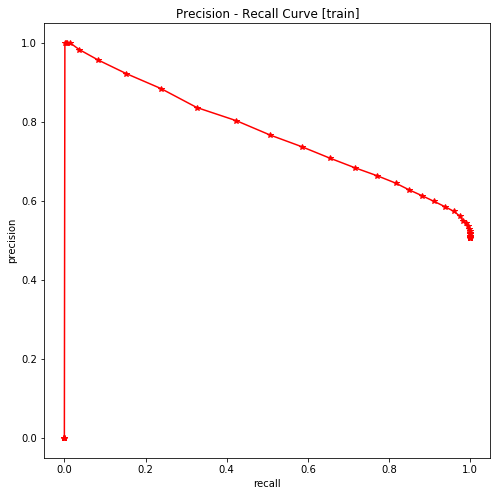

In [116]:
evaluate(y_train, y_train_pred_proba, mode='train')

("best test f1 score: OrderedDict([('f1', 0.6939023910866167), ('precision', "
 "0.5761052986643231), ('recall', 0.8722534491123017), ('thresh', "
 "0.40816326530612246), ('tp', 1707), ('fp', 1256), ('fn', 250), ('tn', 658)])")


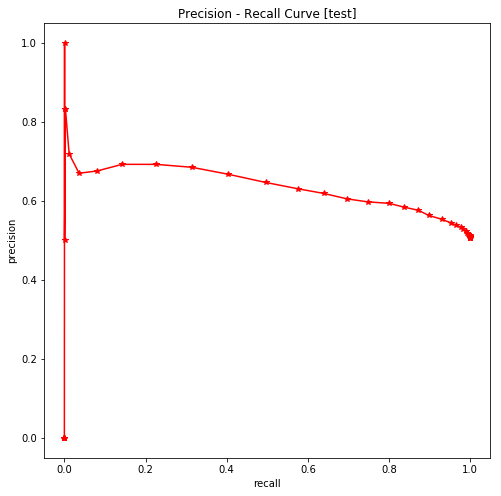

In [117]:
evaluate(y_test, y_test_pred_proba, mode='test')